<a href="https://colab.research.google.com/github/alfrizzle/MSDS-453/blob/master/YI_ALFRED_MSDS453_Assignment_02_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSDS 453: Research/Programming Assignment #2

## Preparing Environment

In [ ]:
!pip install jsonlines

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils

import json
import jsonlines
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import string
import re
import math
import seaborn as sns
import multiprocessing
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pprint
pp = pprint.PrettyPrinter(indent=4)
% matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
!mkdir -p abc
!echo "file" > abc/123.txt
!ls

abc  drive  sample_data


In [ ]:
import os
os.chdir('/content/drive/My Drive/MSDS 453/Assignment 2')

# Now the directory 'abc' is the current working directory.
!ls

abc				    scitech_articles.jl
Assignment2_Instructions.docx	    vectors_models_summary.csv
scitecharticles_corpus_topics.xlsx  Yi_Alfred_MSDS453_Assignment_02_Paper.docx


Reading in corpus (this is the same corpus generated from assignment #1)

In [ ]:
# PATH = '/content/drive/My Drive/MSDS 453/Data/News_Category_Dataset_v2.json'
PATH = '/content/drive/My Drive/MSDS 453/Assignment 2/scitech_articles.jl'

In [ ]:
scitechcorpus = []

with open(PATH) as fr:
    for line in fr.readlines():
        row_obj = json.loads(line)
        scitechcorpus.append(row_obj)


In [ ]:
scitechcorpus[0]

{'Body': 'WASHINGTON (Reuters) - The Trump administration plans to unveil efforts on Friday to crack down on counterfeit and pirated goods sold on major e-commerce sites and urge companies to do more to vet third-party sellers and increase self-policing efforts. Acting Department of Homeland Security Secretary Chad Wolf and White House adviser Peter Navarro will be among officials at a news conference on Friday to discuss the effort at the National Intellectual Property Rights Coordination Center in Arlington, Virginia, administration officials said on Thursday. Foreign sellers face little risk of prosecution, an administration official told Reuters, so strong U.S. government action “is necessary to fundamentally realign incentive structures.” Law enforcement agencies are planning “immediate actions” to identify counterfeit goods and seek “all available statutory authorities to pursue civil fines and other penalties against these entities,” according to a DHS report reported by the Wal

## Data Exploration

Creating dataframe for easier viewing and data exploration

In [ ]:
# df = pd.DataFrame(data=container, columns=["category", "headline", "authors", "link", "short_description", "date"])
df = pd.DataFrame(data = scitechcorpus, columns = ['ID', 'PublishDate', 'Source', 'Topic', 'Title', 'Body', 'URL'])

In [ ]:
#List unique values in the df['XXX'] column
df.Source.unique()

array(['www.reuters.com', 'www.npr.org', 'The Tribune Online',
       'Deccan Herald Online', 'The Times of Israel',
       'The Times of India Online', 'The Hindu Online', 'oneindia',
       'Ministry of Foreign Affairs', 'Business Standard Online',
       'Haaretz.com', 'The Jerusalem Post Online',
       'The Economic Times Online', 'Business Line Online',
       'The Financial Express Online', 'The Express Tribune Online',
       'Mail Today (Electronic Edition)', 'Weizmann Institute of Science',
       'The Nation Online', 'Associated Press of Pakistan Online',
       'Dawn Online', 'Ben-Gurion University of the Negev', 'Quwa Online',
       'Hindustan Times Online', 'Israel Defense Online', 'CTech',
       'ThePrint Online', 'Bhabha Atomic Research Centre', 'Technion',
       'NDTV Online', 'The New Indian Express Online', 'Livemint Online',
       'Daily News and Analysis Online', 'The Pioneer Online',
       'AMOS Spacecom', 'The Indian Express', 'Radio Pakistan Online',
      

In [ ]:
len(df.Source.unique())

61

In [ ]:
T# renaming source names that are a URL
df["Source"]= df["Source"].str.replace("www.reuters.com", "Reuters", case = True) 
df["Source"]= df["Source"].str.replace("www.npr.org", "NPR", case = True) 
df["Source"]= df["Source"].str.replace("www.calcalistech.com", "CTech", case = True) 

# # creating a filter for age column  
# # where age = "Twenty five"  
# filter = data["Team"]=="New Boston Celtics"
  
# # printing only filtered columns  
# data.where(filter).dropna() 

Confirming URLs have been successfully replaced with new source names

In [ ]:
#To select rows whose column value is in list 
sourcelist = ['Reuters', 'NPR', 'CTech']
filter = df.loc[df['Source'].isin(sourcelist)]
filter

,ID,PublishDate,Source,Topic,Title,Body,URL
0,1.0,01/24/2020,Reuters,Proliferation,"U.S. to unveil crackdown on counterfeit, pirat...",WASHINGTON (Reuters) - The Trump administratio...,https://www.reuters.com/article/us-usa-trump-c...
1,2.0,01/23/2020,Reuters,AI,"Uber self-driving cars, with humans in control...",WASHINGTON (Reuters) - Uber Technologies Inc (...,https://www.reuters.com/article/us-uber-self-d...
2,3.0,01/23/2020,Reuters,Energy,Germany to urge next Bolivian leaders to reviv...,BERLIN (Reuters) - Germany will seek talks wit...,https://www.reuters.com/article/us-germany-bol...
3,4.0,01/23/2020,NPR,Cyber,Don't Be Like Jeff Bezos. Here's How To Keep Y...,The phone of Jeff Bezos allegedly was hacked v...,https://www.npr.org/2020/01/23/798630195/dont-...
4,5.0,10/22/2019,NPR,Health,Hospitals Around The World Have A Dire Shortag...,A blood transfusion bag hangs in an operating ...,https://www.npr.org/sections/goatsandsoda/2019...
5,6.0,12/11/2019,NPR,Tech,"44,000-Year-Old Indonesian Cave Painting Is Re...","The scene found in Indonesia shows, among othe...",https://www.npr.org/2019/12/11/786760790/44-00...
6,7.0,01/04/2020,NPR,Health,"Hope, Happiness And Social Connection: Hidden ...",In a new book The Joy of Movement: How Exercis...,https://www.npr.org/sections/health-shots/2020...
7,8.0,01/22/2020,NPR,Bio,Ready For Meat Grown From Animal Cells? A Star...,This chicken from Memphis Meats was produced w...,https://www.npr.org/sections/thesalt/2020/01/2...
8,9.0,01/17/2020,NPR,Environment,"2020 So Far: Fires, Floods, And Quakes",Parroquia Inmaculada Concepción church in Guay...,https://www.npr.org/2020/01/09/795017172/2020-...
9,10.0,01/02/2020,Reuters,Space,Israel Aerospace to build Israel's next commun...,JERUSALEM (Reuters) - State-owned Israel Aeros...,https://www.reuters.com/article/us-il-aerospac...


Quick check on body contents using handy module I can use to wrap long text





In [ ]:
import textwrap 

In [ ]:
# Wrap this text. 
wrapper = textwrap.TextWrapper(width=70) 
  
# word_list = wrapper.wrap(text=value) 
  
# # Print each line. 
# for element in word_list: 
#     print(element) 

In [ ]:
wrapper.wrap(df['Body'][10])

['DETROIT/LAS VEGAS (Reuters) - Self-driving cars employ lidar, a remote',
 'sensing technology using pulsed laser light the way radar uses radio',
 'waves, and lidar makers waiting for the automotive market to take off',
 'are courting new customers who would use the technology for everything',
 'from monitoring cattle to helping a disc jockey synchronize dance',
 'music. Ouster, a San Francisco tech startup, is tapping new markets',
 'including delivery robots, disaster relief and even an approach from',
 'the disc jockey. Another Bay area startup, AEye, is talking to a bank',
 'that wants to monitor cattle growth to ensure the financial health of',
 'a rancher who is a loan customer. Alternative uses and customers are',
 'needed to keep revenue flowing at lidar startups waiting for the',
 'expected boom in self-driving cars, which still looks to be years',
 'away. “We never took an exclusively automotive view of lidar,” said',
 'Angus Pacala, Ouster chief executive and co-founder. “

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
ID             499 non-null float64
PublishDate    499 non-null object
Source         499 non-null object
Topic          499 non-null object
Title          499 non-null object
Body           499 non-null object
URL            499 non-null object
dtypes: float64(1), object(6)
memory usage: 27.4+ KB


In [ ]:
df.isnull().sum()

ID             0
PublishDate    0
Source         0
Topic          0
Title          0
Body           0
URL            0
dtype: int64

Creating dict keys for all topics in corpus

In [ ]:
topics, topic_data = df['Topic'].unique().tolist(), dict()

for topic in topics:
    topic_data["df_{}".format(topic.lower().replace(" ", ""))] = df[(df['Topic'] == topic)]
    
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

In [ ]:
df['Topic'].value_counts().sort_values(ascending=False).plot.bar

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x7ff6977bd550>>

Text(0, 0.5, 'Number of Articles')

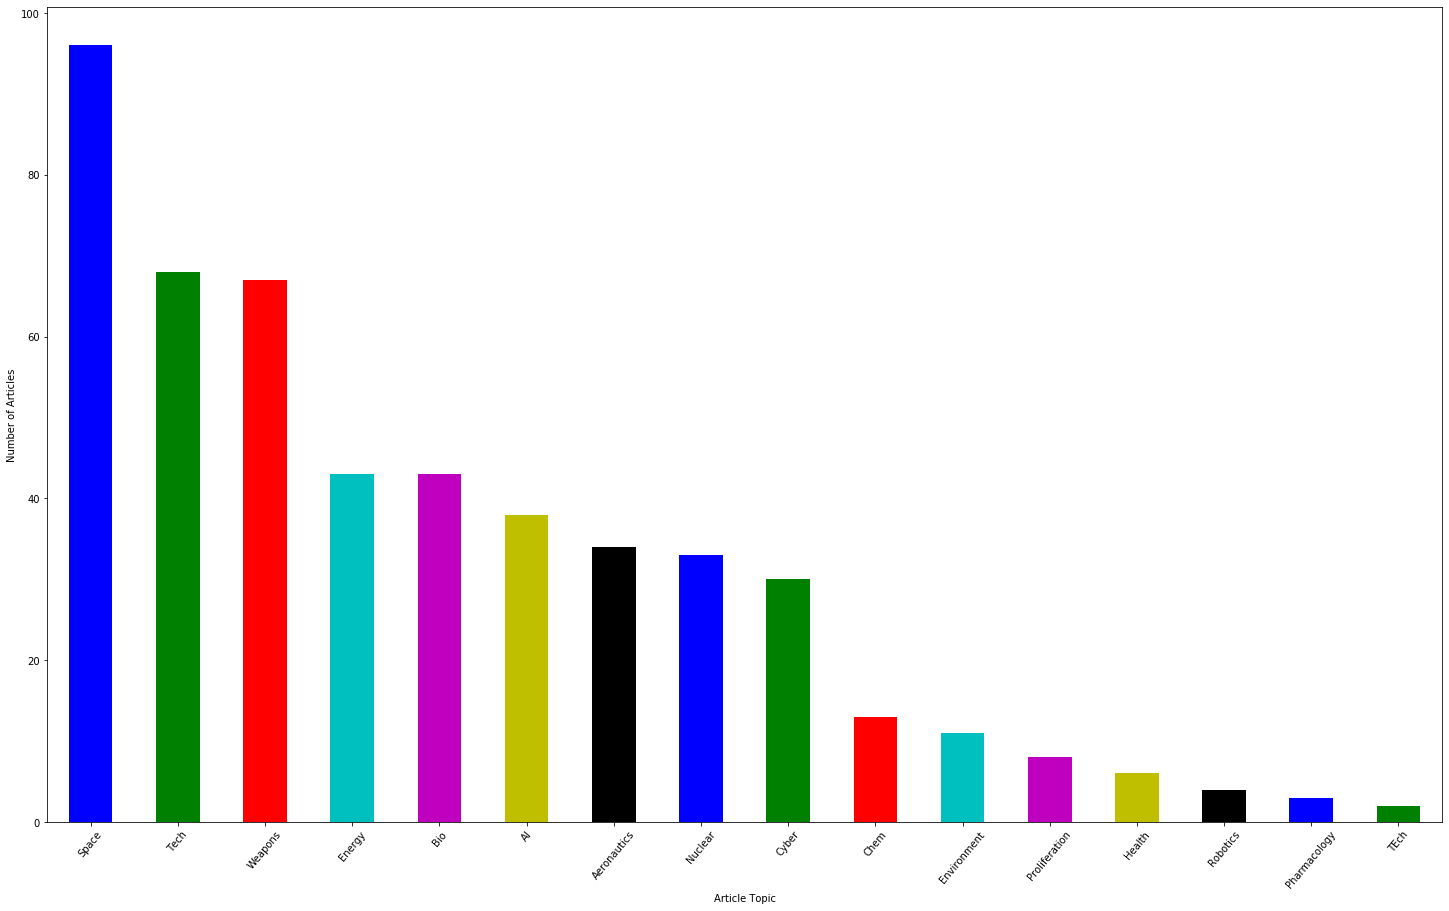

In [ ]:
plt.figure(figsize=(25,15))
cmapper = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
df['Topic'].value_counts().sort_values(ascending=False).plot.bar(color=cmapper)
plt.xticks(rotation=50)
plt.xlabel("Article Topic")
plt.ylabel("Number of Articles")

Noticed there are a couple of items under a "TEch" topic (wrong case). I'll look up the rows with the incorrect case and replace them with "Tech"

In [ ]:
df.loc[df['Topic'] == 'TEch']

,ID,PublishDate,Source,Topic,Title,Body,URL
362,367.0,1/2/2018,The Times of India Online,TEch,India's Premier Technological Institutes To Jo...,NEW DELHI: In what could help India leapfrog o...,timesofindia.indiatimes.com
428,434.0,8/22/2018,Ben-Gurion University of the Negev,TEch,Ben-Gurion University of the Negev - Dojo By B...,"Dojo by BullGuard, a market leader in IoT secu...",http://in.bgu.ac.il/en/pages/news/bullguard_bg...


In [ ]:
# correcting case
df["Topic"]= df["Topic"].str.replace("TEch", "Tech", case = True)

In [ ]:
# confirming that the issue was resolved
df.loc[df['Topic'] == 'TEch']

,ID,PublishDate,Source,Topic,Title,Body,URL


Text(0, 0.5, 'Number of Articles')

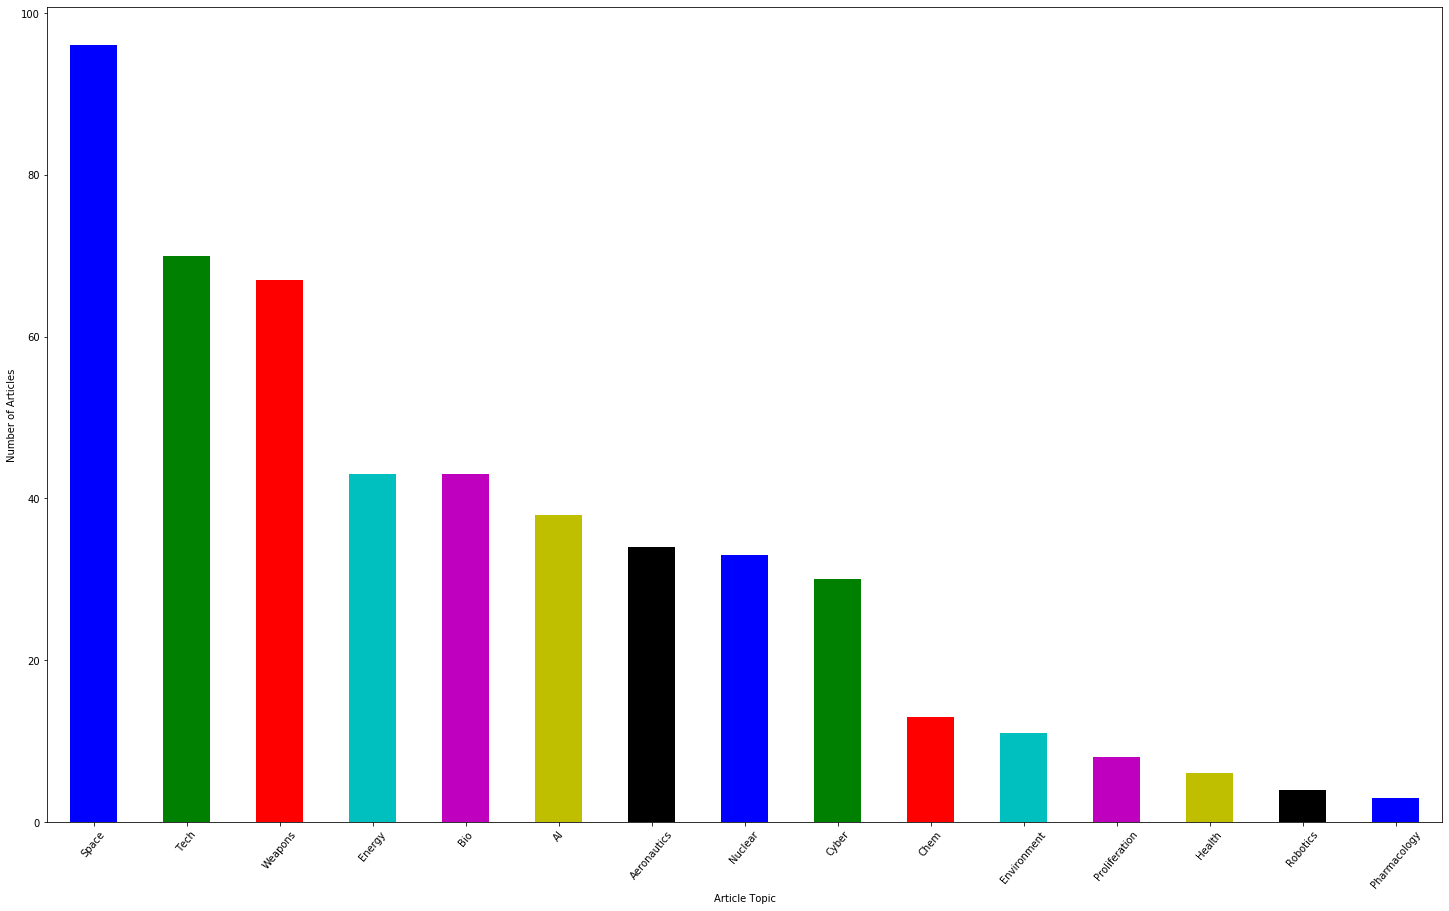

In [ ]:
plt.figure(figsize=(25,15))
cmapper = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
df['Topic'].value_counts().sort_values(ascending=False).plot.bar(color=cmapper)
plt.xticks(rotation=50)
plt.xlabel("Article Topic")
plt.ylabel("Number of Articles")

In [ ]:
df.Topic.unique()

array(['Proliferation', 'AI', 'Energy', 'Cyber', 'Health', 'Tech', 'Bio',
       'Environment', 'Space', 'Weapons', 'Aeronautics', 'Nuclear',
       'Chem', 'Robotics', 'Pharmacology'], dtype=object)

In [ ]:
topic_count = len(df.Topic.unique())
print('Total # of topics:', topic_count)

Total # of topics: 15


In [ ]:
df['Topic'].value_counts()

Space            96
Tech             70
Weapons          67
Bio              43
Energy           43
AI               38
Aeronautics      34
Nuclear          33
Cyber            30
Chem             13
Environment      11
Proliferation     8
Health            6
Robotics          4
Pharmacology      3
Name: Topic, dtype: int64

## Tokenization

In [ ]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Two Functions:

*   **tokenize_and_stem**: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
*   **tokenize_only**: tokenizes the synopsis only

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes.

In [ ]:
# tokenizer and stemmer that returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Tokenization method from Brownlee Ch.5

In [ ]:
# # split into words
# tokens = word_tokenize(text)
# # convert to lower case
# tokens = [w.lower() for w in tokens]
# # prepare regex for char filtering
# re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# # remove punctuation from each word
# stripped = [re_punc.sub('', w) for w in tokens]
# # remove remaining tokens that are not alphabetic
# words = [word for word in stripped if word.isalpha()]
# # filter out stop words
# stop_words = set(stopwords.words('english'))
# words = [w for w in words if not w in stop_words]

Resetting "topics" variable to account for the case correction above

In [ ]:
topics, topic_data = df['Topic'].unique().tolist(), dict()

for topic in topics:
    topic_data["df_{}".format(topic.lower().replace(" ", ""))] = df[(df['Topic'] == topic)]
    
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

### Note on parameters for vectorization methods

A couple things to note about the parameters for the following document vectorization methods:

*   **max_df**: this is the maximum frequency within the documents a given feature can have to be used in the matrix. If the term is in greater than 80% of the documents it probably carries little meaning (in the context of the article)
*  **min_idf**: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
*   **ngram_range**: this just means I'll look at unigrams, bigrams and trigrams. See n-grams 

**Alternative Explanation**

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

*   max_df = 0.50 means "ignore terms that appear in more than 50% of the  documents".
*   max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:

*   min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
*   min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


## Approach #1: Analyst Judgment

Using CountVectorizer() to analyze term frequency in corpus's body text

In [ ]:
# Count Vectorizer for entire model 

# cvector = CountVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.2, stop_words=stopwords,
#                                  tokenizer = tokenize_only, ngram_range=(1,2))


cvector = CountVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS)
# cvector.fit(df['Body'])
cvector.fit_transform(df['Body'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<499x153 sparse matrix of type '<class 'numpy.int64'>'
	with 24035 stored elements in Compressed Sparse Row format>

In [ ]:
cvector_matrix = cvector.fit_transform(df['Body']) #fit the vectorizer to text in articles

cvector_matrix.shape

(499, 153)

In [ ]:
len(cvector.get_feature_names())

153

In [ ]:
list(cvector.vocabulary_.keys())[:50]

['major',
 'companies',
 'security',
 'will',
 'among',
 'news',
 'national',
 'center',
 'said',
 'strong',
 'government',
 'according',
 'report',
 'online',
 'information',
 'united',
 'states',
 'better',
 'global',
 'may',
 'year',
 'time',
 'including',
 'china',
 'group',
 'ltd',
 'last',
 '2018',
 '15',
 'see',
 'united states',
 'technologies',
 'control',
 'company',
 'data',
 'support',
 'development',
 'first',
 'one',
 'new',
 'use',
 'three',
 'using',
 'top',
 'technology',
 'used',
 'second',
 'well',
 'industry',
 'co']

### Document-Term Matrix (Analyst Judgment)

In [ ]:
cvector_matrix.toarray()

array([[0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [2, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 3, ..., 7, 0, 1],
       [0, 3, 1, ..., 2, 0, 0],
       [1, 3, 1, ..., 9, 1, 4]])

In [ ]:
df_cvector = pd.DataFrame(cvector_matrix.toarray(), columns = cvector.get_feature_names())
df_cvector.head(10)

,000,10,100,15,2018,30,according,added,advanced,agency,among,amp,another,areas,based,better,body,business,center,china,circulation,co,companies,company,control,cost,countries,country,critical,daily,data,defense,delhi,description,description source,descriptor,developed,development,domestic,economic,...,second,security,see,set,several,source,source descriptor,south,space,state,states,strong,support,supports,system,systems,technologies,technology,though,three,time,times,top,two,united,united states,url,us,use,used,using,various,website,well,will,within,work,world,year,years
0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,2,0
1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,1,1,0,0,1,4,0,0,0,1,0
2,2,0,0,1,2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,6,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,0,1,0,0,0,0,1,10,1,1,0,0,1,0,0,0,0,1,2
4,4,1,3,0,0,2,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,6,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,1,0
5,3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,1,0,0,7
6,0,0,0,0,1,0,0,0,0,0,3,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,1,0,0,1,4,0,0,0,1,0
7,0,0,0,0,2,0,1,0,0,0,1,0,1,0,9,0,0,0,0,0,0,1,2,7,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,1,0,3,0,0,1,0,0,1,4,0,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2


### Term Frequency Sorted

Function to generate top n words in corpus by frequency

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
cvector_top20 = get_top_n_words(df['Body'], 20)
for word, freq in cvector_top20:
    print(word, freq)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


india 1460
will 1363
technology 1273
research 1152
science 1133
said 1095
pakistan 889
new 875
first 869
english 771
space 755
government 684
daily 683
development 665
url 658
indian 590
one 584
center 556
left 549
top 547


In [ ]:
# converting top 20 terms into dataframe
df_cvranking = pd.DataFrame(cvector_top20, columns = ['Term', 'Count'])
df_cvranking

,Term,Count
0,india,1460
1,will,1363
2,technology,1273
3,research,1152
4,science,1133
5,said,1095
6,pakistan,889
7,new,875
8,first,869
9,english,771


In [ ]:
def create_tf_matrix(topic):
    return cvector.transform(df[df['Topic'] == topic].Body)

In [ ]:
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

### Term Frequency Matrices (by Topic)

In [ ]:
proliferation_matrix = create_tf_matrix('Proliferation')
ai_matrix = create_tf_matrix('AI')
energy_matrix = create_tf_matrix('Energy')
cyber_matrix = create_tf_matrix('Cyber')
health_matrix = create_tf_matrix('Health')
tech_matrix = create_tf_matrix('Tech')
bio_matrix = create_tf_matrix('Bio')
environment_matrix = create_tf_matrix('Environment')
space_matrix = create_tf_matrix('Space')
weapons_matrix = create_tf_matrix('Weapons')
aeronautics_matrix = create_tf_matrix('Aeronautics')
nuclear_matrix = create_tf_matrix('Nuclear')
chem_matrix = create_tf_matrix('Chem')
robotics_matrix = create_tf_matrix('Robotics')
pharm_matrix = create_tf_matrix('Pharmacology')

In [ ]:
def create_term_freq(matrix):
    topic_words = matrix.sum(axis=0)
    topic_words_freq = [(word, topic_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
    return pd.DataFrame(list(sorted(topic_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', 'Frequency'])

In [ ]:
def create_wordcloud(topic):
    text = " ".join(desc for desc in topic_data[topic]['Body'])
    wordcloud = WordCloud(width=1500, height=800, max_font_size=200, background_color = 'white', stopwords = STOPWORDS).generate(text)
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

List of top 10 most frequent terms in the body text according to topic

#### Proliferation

In [ ]:
create_term_freq(proliferation_matrix).head(10)
#create_wordcloud('df_proliferation')

,Terms,Frequency
0,pakistan,26
1,said,24
2,india,22
3,group,14
4,will,12
5,international,11
6,companies,10
7,states,10
8,china,10
9,new,10


#### AI

In [ ]:
create_term_freq(ai_matrix).head(10)
#create_wordcloud('df_ai')

,Terms,Frequency
0,will,122
1,said,111
2,data,109
3,india,81
4,research,80
5,new,73
6,top,73
7,technology,67
8,system,58
9,left,54


#### Energy

In [ ]:
create_term_freq(energy_matrix).head(10)
# create_wordcloud('df_energy')

,Terms,Frequency
0,pakistan,178
1,energy,159
2,power,142
3,said,136
4,will,127
5,project,108
6,government,89
7,english,67
8,daily,65
9,india,65


#### Cyber

In [ ]:
create_term_freq(cyber_matrix).head(10)
# create_wordcloud('df_cyber')

,Terms,Frequency
0,security,74
1,top,57
2,will,48
3,new,44
4,national,43
5,ministry,43
6,information,42
7,systems,42
8,said,41
9,website,38


#### Health

In [ ]:
create_term_freq(health_matrix).head(10)
# create_wordcloud('df_health')

,Terms,Frequency
0,people,16
1,new,15
2,countries,15
3,may,10
4,company,9
5,used,9
6,research,9
7,among,8
8,said,8
9,one,7


#### Tech

In [ ]:
create_term_freq(tech_matrix).head(10)
# create_wordcloud('df_tech')

,Terms,Frequency
0,science,964
1,technology,900
2,research,677
3,development,364
4,first,325
5,national,242
6,center,239
7,government,221
8,one,212
9,left,197


#### Bio

In [ ]:
create_term_freq(bio_matrix).head(10)
# create_wordcloud('df_bio')

,Terms,Frequency
0,india,124
1,used,89
2,research,84
3,english,79
4,top,74
5,left,74
6,new,73
7,url,73
8,daily,70
9,will,69


#### Environment

In [ ]:
create_term_freq(environment_matrix).head(10)
# create_wordcloud('df_environment')

,Terms,Frequency
0,india,35
1,said,33
2,will,22
3,project,22
4,policy,22
5,pakistan,21
6,english,20
7,daily,19
8,government,16
9,power,14


#### Space

In [ ]:
create_term_freq(space_matrix).head(10)
# create_wordcloud('df_space')

,Terms,Frequency
0,space,573
1,will,470
2,india,410
3,launch,351
4,said,263
5,english,223
6,daily,206
7,times,192
8,first,188
9,indian,147


#### Weapons

In [ ]:
create_term_freq(weapons_matrix).head(10)
# create_wordcloud('df_weapons')

,Terms,Frequency
0,pakistan,278
1,india,214
2,said,178
3,defense,166
4,will,137
5,english,119
6,range,118
7,new,97
8,systems,91
9,military,90


#### Aeronautics

In [ ]:
create_term_freq(aeronautics_matrix).head(10)
# create_wordcloud('df_aeronautics')

,Terms,Frequency
0,pakistan,95
1,india,72
2,will,62
3,said,58
4,top,58
5,url,57
6,english,53
7,new,47
8,daily,46
9,first,44


#### Nuclear

In [ ]:
create_term_freq(nuclear_matrix).head(10)
# create_wordcloud('df_nuclear')

,Terms,Frequency
0,india,175
1,power,98
2,energy,94
3,will,78
4,states,76
5,english,69
6,new,66
7,pakistan,66
8,said,63
9,two,62


#### Chem

In [ ]:
create_term_freq(chem_matrix).head(10)
# create_wordcloud('df_chem')

,Terms,Frequency
0,use,61
1,states,50
2,used,49
3,united,47
4,new,40
5,research,40
6,india,39
7,may,37
8,center,36
9,united states,36


#### Robotics

In [ ]:
create_term_freq(robotics_matrix).head(10)
# create_wordcloud('df_robotics')

,Terms,Frequency
0,used,31
1,one,19
2,using,18
3,first,17
4,power,17
5,use,15
6,control,14
7,many,14
8,two,13
9,science,13


#### Pharmacology

In [ ]:
create_term_freq(pharm_matrix).head(10)
#create_wordcloud('df_pharmacology')

,Terms,Frequency
0,used,8
1,one,7
2,left,7
3,government,6
4,states,6
5,will,5
6,may,5
7,research,5
8,india,5
9,indian,5


## Approach #2: TF-IDF

In [ ]:
# TF-IDF Vectorizer for entire model 

# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.1, stop_words='english',
#                                  use_idf=True, tokenizer=tokenize_only, ngram_range=(1,2))


tfidfvector = TfidfVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS,
                              use_idf = True)

tfidfvector.fit_transform(df['Body'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<499x153 sparse matrix of type '<class 'numpy.float64'>'
	with 24035 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_matrix = tfidfvector.fit_transform(df['Body']) #fit the vectorizer to text in articles

tfidf_matrix.shape

(499, 153)

In [ ]:
len(tfidfvector.get_feature_names())

153

### Document-Term Matrix (TF-IDF)

In [ ]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.23053774,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10262575,
        0.        ],
       [0.13496943, 0.        , 0.        , ..., 0.        , 0.        ,
        0.06447832],
       ...,
       [0.        , 0.        , 0.05840361, ..., 0.12179105, 0.        ,
        0.01628314],
       [0.        , 0.0567891 , 0.01971082, ..., 0.03523169, 0.        ,
        0.        ],
       [0.01970796, 0.06486204, 0.02251284, ..., 0.18108048, 0.01872589,
        0.07531993]])

In [ ]:
df_tfidfvector = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidfvector.get_feature_names())
df_tfidfvector.head(10)

,000,10,100,15,2018,30,according,added,advanced,agency,among,amp,another,areas,based,better,body,business,center,china,circulation,co,companies,company,control,cost,countries,country,critical,daily,data,defense,delhi,description,description source,descriptor,developed,development,domestic,economic,...,second,security,see,set,several,source,source descriptor,south,space,state,states,strong,support,supports,system,systems,technologies,technology,though,three,time,times,top,two,united,united states,url,us,use,used,using,various,website,well,will,within,work,world,year,years
0,0.000000,0.00000,0.000000,0.133526,0.132653,0.00000,0.131794,0.000000,0.0,0.000000,0.146842,0.0,0.000000,0.0,0.000000,0.143601,0.000000,0.0,0.143078,0.312891,0.0,0.000000,0.435595,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.138101,0.146842,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.119914,0.143078,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.116884,0.000000,0.000000,0.000000,0.124597,0.128081,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.152889,0.0,0.000000,0.000000,0.230538,0.000000
1,0.000000,0.00000,0.000000,0.118880,0.354311,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.121285,0.000000,0.321210,0.259511,0.000000,0.00000,0.000000,0.000000,0.000000,0.519023,0.0,0.0,0.0,0.0,0.0,0.000000,0.09404,0.0,0.0,...,0.106454,0.000000,0.130736,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125121,0.0,0.000000,0.000000,0.130243,0.089907,0.0,0.111604,0.104064,0.000000,0.125121,0.089907,0.000000,0.000000,0.0,0.000000,0.107070,0.106454,0.114033,0.0,0.0,0.118104,0.272240,0.0,0.000000,0.000000,0.102626,0.000000
2,0.134969,0.00000,0.000000,0.074278,0.147585,0.00000,0.073315,0.000000,0.0,0.072844,0.000000,0.0,0.080472,0.0,0.000000,0.079883,0.000000,0.0,0.000000,0.058018,0.0,0.000000,0.080771,0.200696,0.000000,0.000000,0.00000,0.063421,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.081686,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.073315,0.000000,0.000000,0.078177,0.0,0.000000,0.196162,0.000000,0.000000,0.0,0.069731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.133028,0.000000,0.0,0.0,0.000000,0.255148,0.0,0.000000,0.000000,0.000000,0.064478
3,0.054121,0.00000,0.000000,0.000000,0.059180,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.064777,0.107303,0.260075,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.308053,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.053497,0.000000,0.000000,0.000000,0.0,0.055923,0.104290,0.000000,0.062696,0.000000,0.000000,0.000000,0.0,0.047122,0.536514,0.053343,0.057140,0.0,0.0,0.059180,0.000000,0.0,0.000000,0.000000,0.051424,0.103421
4,0.189817,0.05206,0.162624,0.000000,0.000000,0.11153,0.051554,0.056587,0.0,0.000000,0.057440,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.040798,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.64134,0.267580,0.040492,0.032011,0.057009,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.225514,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.046907,0.000000,0.000000,0.039501,0.0,0.049034,0.091443,0.047454,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.103780,0.000000,0.0,0.000000,0.145340,0.045090,0.000000
5,0.291214,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.117498,0.0,0.115753,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.11

In [ ]:
tfidf_terms = tfidfvector.get_feature_names()
tfidf_terms[:20]

['000',
 '10',
 '100',
 '15',
 '2018',
 '30',
 'according',
 'added',
 'advanced',
 'agency',
 'among',
 'amp',
 'another',
 'areas',
 'based',
 'better',
 'body',
 'business',
 'center',
 'china']

### TD-IDF Ranking by Score Weight

In [ ]:
# sum tfidf frequency of each term through documents
sums = tfidf_matrix.sum(axis=0)

In [ ]:
# connecting term to its sums frequency
data = []
for col, term in enumerate(tfidf_terms):
    data.append( (term, sums[0,col] ))

In [ ]:
tfidf_ranking = pd.DataFrame(data, columns=['term','rank'])
tfidf_ranking.sort_values('rank', ascending=False)

,term,rank
54,india,58.760448
147,will,52.902854
111,said,48.478185
96,pakistan,47.155749
121,space,36.524835
...,...,...
124,strong,8.370920
80,media,8.341315
5,30,8.184113
45,generally,7.996893


In [ ]:
# printing top 20 terms based on TF-IDF score

df_tfidfranking = tfidf_ranking.sort_values('rank', ascending = False).head(20)
df_tfidfranking

,term,rank
54,india,58.760448
147,will,52.902854
111,said,48.478185
96,pakistan,47.155749
121,space,36.524835
130,technology,35.956371
109,research,35.838034
41,english,35.250616
87,new,33.613646
29,daily,32.875381


In [ ]:
# printing all terms by TF-IDF ranking
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(tfidf_ranking.sort_values('rank', ascending = False))

                      term       rank
54                   india  58.760448
147                   will  52.902854
111                   said  48.478185
96                pakistan  47.155749
121                  space  36.524835
130             technology  35.956371
109               research  35.838034
41                 english  35.250616
87                     new  33.613646
29                   daily  32.875381
55                  indian  32.564990
134                  times  29.483151
44                   first  28.948206
112                science  28.614108
47              government  26.776983
67                  launch  25.949959
142                   used  24.275988
31                 defense  23.100078
94                  online  22.892080
102                project  22.879812
100                  power  22.824587
40                  energy  22.677927
23                 company  22.569278
95          online english  22.374200
39                economic  22.007857
136         

### Term Comparison (Approach 1 vs Approach 2)

Comparing ranks from approach 1 and 2

In [ ]:
print(df_cvranking,'\n')
print(df_tfidfranking)

           Term  Count
0         india   1460
1          will   1363
2    technology   1273
3      research   1152
4       science   1133
5          said   1095
6      pakistan    889
7           new    875
8         first    869
9       english    771
10        space    755
11   government    684
12        daily    683
13  development    665
14          url    658
15       indian    590
16          one    584
17       center    556
18         left    549
19          top    547 

           term       rank
54        india  58.760448
147        will  52.902854
111        said  48.478185
96     pakistan  47.155749
121       space  36.524835
130  technology  35.956371
109    research  35.838034
41      english  35.250616
87          new  33.613646
29        daily  32.875381
55       indian  32.564990
134       times  29.483151
44        first  28.948206
112     science  28.614108
47   government  26.776983
67       launch  25.949959
142        used  24.275988
31      defense  23.100078
94

## Approach #3: Doc2vec

### Processing Corpus Text

In [ ]:
##############################
### Utility Functions 
##############################
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs

codelist = ['\r', '\n', '\t']    

# text parsing function for entire document string
def parse_doc(text):
    text = text.lower()
    text = re.sub(r'&(.)+', "", text)  # no & references  
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    text = re.sub(r"[^\w\d'\s]+", '', text)  # no punct except single quote 
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # no non-ASCII strings    
    if text.isdigit(): text = ""  # omit words that are all digits    
    for code in codelist:
        text = re.sub(code, ' ', text)  # get rid of escape codes  
    # replace multiple spacess with one space
    text = re.sub('\s+', ' ', text)        
    return text

# text parsing for words within entire document string
# splits the document string into words/tokens
# parses the words and then recreates a document string
# returns list of parsed words/tokens and parsed document string
def parse_words(text): 
    # split document into individual words
    tokens=text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # filter out stop words if requested
    if DROP_STOPWORDS:
        tokens = [w for w in tokens if not w in stoplist]         
    # perform word stemming if requested
    if STEMMING:
        ps = PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return tokens, text 


Function to process documents

In [ ]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    # stop_words = set(stopwords.words('english'))
    stop_words = STOPWORDS
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

In [ ]:
# #read in class corpus csv into python
# data=pd.read_csv('Class Corpus.csv')

#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=df['Title'].iloc[i]
    titles.append(temp_text)
    
#create empty list to store text documents titles
topicslist=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=df['Topic'].iloc[i]
    topicslist.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=df['Body'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the dataframe.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [ ]:
final_processed_text

['washington reuters trump administration plans unveil efforts friday crack counterfeit pirated goods major ecommerce sites companies thirdparty sellers increase selfpolicing efforts acting department homeland security secretary white house adviser peter navarro among officials conference friday discuss effort national intellectual property rights coordination center arlington virginia administration officials thursday foreign sellers little prosecution administration official reuters strong government action necessary fundamentally realign incentive enforcement agencies planning identify counterfeit goods available statutory authorities pursue civil fines penalties according report reported street journal thursday confirmed administration official trump administration seeking legal authority explicitly permit government injunctive relief thirdparty marketplaces intermediaries dealing counterfeit official confirmed official companies adopt practices administration believes substantiall

### Create TaggedDocument

In [ ]:
def clean_text(s):
    """
    clean the sentence for text processing: lowercase, punctuation
    :param s: input string
    :return: string
    """
    words = str(s).lower().split()
    return " ".join(words)

In [ ]:
documents = [TaggedDocument(words=clean_text(s).split(), tags=[i]) for i, s in enumerate(final_processed_text)]
documents

[TaggedDocument(words=['washington', 'reuters', 'trump', 'administration', 'plans', 'unveil', 'efforts', 'friday', 'crack', 'counterfeit', 'pirated', 'goods', 'major', 'ecommerce', 'sites', 'companies', 'thirdparty', 'sellers', 'increase', 'selfpolicing', 'efforts', 'acting', 'department', 'homeland', 'security', 'secretary', 'white', 'house', 'adviser', 'peter', 'navarro', 'among', 'officials', 'conference', 'friday', 'discuss', 'effort', 'national', 'intellectual', 'property', 'rights', 'coordination', 'center', 'arlington', 'virginia', 'administration', 'officials', 'thursday', 'foreign', 'sellers', 'little', 'prosecution', 'administration', 'official', 'reuters', 'strong', 'government', 'action', 'necessary', 'fundamentally', 'realign', 'incentive', 'enforcement', 'agencies', 'planning', 'identify', 'counterfeit', 'goods', 'available', 'statutory', 'authorities', 'pursue', 'civil', 'fines', 'penalties', 'according', 'report', 'reported', 'street', 'journal', 'thursday', 'confirmed'

### Training Model

In [ ]:
print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)


Begin Doc2Vec Work

Number of processor cores: 2


In [ ]:
model_base = Doc2Vec(documents, vector_size = 1000, window = 2, min_count = 1, workers = cores)

### Document-Term Matrix (Doc2vec)

In [ ]:
df_doc2vec = pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model_base.infer_vector(processed_text[i])).transpose()
    df_doc2vec=pd.concat([df_doc2vec,vector], axis=0)

In [ ]:
df_doc2vec=df_doc2vec.reset_index()

In [ ]:
doc_titles={'Title': titles}
t=pd.DataFrame(doc_titles)

In [ ]:
doc_topics={'Topic': topicslist}
top=pd.DataFrame(doc_topics)

In [ ]:
df_doc2vec=pd.concat([df_doc2vec,t, top], axis=1)

In [ ]:
df_doc2vec=df_doc2vec.drop('index', axis=1)

In [ ]:
df_doc2vec['Topic']

0      Proliferation
1                 AI
2             Energy
3              Cyber
4             Health
           ...      
148          Weapons
149           Energy
150          Nuclear
151           Energy
152           Energy
Name: Topic, Length: 153, dtype: object

In [ ]:
df_doc2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,Title,Topic
0,-0.016714,-0.002703,-0.001064,0.006911,0.006103,-0.004152,0.012299,-0.004790,-0.007660,0.001730,0.009924,-0.002417,0.001165,0.000620,-0.005176,-0.003761,-0.007446,-0.003576,-0.003835,-0.007515,0.001390,-0.012944,0.009756,-0.006330,0.016792,-0.006374,0.003969,0.004384,-0.015262,0.001062,0.005701,0.000504,-0.000681,-0.004124,-0.006952,-0.004142,0.004681,0.011514,0.012823,0.008008,...,0.002277,0.008379,0.008950,0.003331,0.001170,0.016911,0.011992,-0.003311,-0.009338,0.014357,0.012227,-0.004844,0.009526,0.002949,0.004477,-0.003396,-0.004918,-0.000908,-0.006786,-0.006574,-0.001522,-0.005772,-0.007667,0.013362,0.008444,-0.000256,0.006015,-0.012560,-0.001647,-0.009215,0.008725,0.005368,0.000010,-0.006644,0.000311,-0.010940,-0.001813,-0.005107,"U.S. to unveil crackdown on counterfeit, pirat...",Proliferation
1,-0.015355,-0.002244,-0.001140,0.006573,0.005406,-0.003628,0.011536,-0.004452,-0.007002,0.001696,0.010072,-0.001395,0.000872,0.000520,-0.005335,-0.003202,-0.007014,-0.003474,-0.003450,-0.006929,0.000913,-0.012465,0.009580,-0.004933,0.015488,-0.006295,0.003953,0.004054,-0.013843,0.000423,0.005198,0.000254,-0.001115,-0.004071,-0.005792,-0.004155,0.004445,0.011061,0.012093,0.008089,...,0.002001,0.007794,0.008421,0.002620,0.001148,0.015925,0.011526,-0.003151,-0.008958,0.013357,0.011218,-0.004691,0.008576,0.002767,0.003279,-0.002810,-0.004650,-0.000677,-0.006492,-0.006336,-0.002232,-0.004838,-0.007881,0.012671,0.007847,-0.000236,0.005532,-0.012199,-0.002609,-0.008852,0.008182,0.004364,0.000557,-0.005726,0.000057,-0.010720,-0.001918,-0.005360,"Uber self-driving cars, with humans in control...",AI
2,-0.017525,-0.003103,-0.001405,0.006940,0.007415,-0.004618,0.013684,-0.005228,-0.008531,0.002308,0.011662,-0.001586,0.001406,0.001052,-0.005812,-0.003813,-0.008514,-0.003879,-0.004109,-0.008455,0.001364,-0.014807,0.010540,-0.006600,0.018677,-0.006901,0.003862,0.004267,-0.017284,0.001449,0.005633,0.000768,-0.001568,-0.004833,-0.007061,-0.004826,0.004652,0.012619,0.014105,0.008888,...,0.002406,0.008619,0.009738,0.003393,0.001339,0.018680,0.012852,-0.003832,-0.010148,0.015477,0.013580,-0.004953,0.009828,0.003653,0.004570,-0.002993,-0.005182,-0.000866,-0.007992,-0.007314,-0.001703,-0.006582,-0.009282,0.014594,0.008953,0.000043,0.006513,-0.013810,-0.002133,-0.010720,0.009456,0.005044,0.000194,-0.006830,0.000783,-0.012552,-0.002068,-0.006406,Germany to urge next Bolivian leaders to reviv...,Energy
3,-0.044754,-0.008454,-0.004651,0.017992,0.017704,-0.010284,0.032853,-0.014024,-0.021193,0.004541,0.028284,-0.005234,0.001891,0.001715,-0.015157,-0.010312,-0.019602,-0.010308,-0.009631,-0.021350,0.001990,-0.035443,0.026108,-0.015301,0.044455,-0.017689,0.010222,0.010126,-0.040959,0.003072,0.014466,0.000266,-0.002255,-0.011398,-0.018153,-0.012151,0.012624,0.030638,0.034885,0.022284,...,0.005863,0.021472,0.025447,0.006832,0.002085,0.045686,0.032054,-0.009140,-0.025145,0.038546,0.033499,-0.012977,0.024723,0.008588,0.010645,-0.008441,-0.012507,-0.001671,-0.018431,-0.017194,-0.005261,-0.015726,-0.021687,0.035972,0.021222,-0.000692,0.016270,-0.034726,-0.005284,-0.025552,0.022869,0.013880,-0.000113,-0.016457,0.000543,-0.030661,-0.004320,-0.014719,Don't Be Like Jeff Bezos. Here's How To Keep Y...,Cyber
4,-0.036535,-0.006856,-0.003238,0.014893,0.013768,-0.008496,0.026820,-0.010764,-0.017175,0.004444,0.022918,-0.004097,0.002329,0.002533,-0.012471,-0.007554,-0.016557,-0.008098,-0.007970,-0.016988,0.002334,-0.028944,0.022225,-0.012462,0.037192,-0.013887,0.008494,0.008181,-0.033395,0.002365,0.011969,0.000907,-0.002190,-0.009564,-0.014892,-0.010018,0.010317,0.025387,0.028101,0.018252,...,0.004798,0.018022,0.020778,0.006341,0.001981,0.037122,0.025767,-0.007796,-0.020663,0.030393,0.027623,-0.0101

Rearranging columns so it's easier to identify the specific document titles and topics in the matrix

In [ ]:
cols = list(df_doc2vec.columns)
cols = [cols[-1]] + cols[:-1]
df_doc2vec = df_doc2vec[cols]
df_doc2vec.head()

,Topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,Title
0,Proliferation,-0.016714,-0.002703,-0.001064,0.006911,0.006103,-0.004152,0.012299,-0.004790,-0.007660,0.001730,0.009924,-0.002417,0.001165,0.000620,-0.005176,-0.003761,-0.007446,-0.003576,-0.003835,-0.007515,0.001390,-0.012944,0.009756,-0.006330,0.016792,-0.006374,0.003969,0.004384,-0.015262,0.001062,0.005701,0.000504,-0.000681,-0.004124,-0.006952,-0.004142,0.004681,0.011514,0.012823,...,0.002113,0.002277,0.008379,0.008950,0.003331,0.001170,0.016911,0.011992,-0.003311,-0.009338,0.014357,0.012227,-0.004844,0.009526,0.002949,0.004477,-0.003396,-0.004918,-0.000908,-0.006786,-0.006574,-0.001522,-0.005772,-0.007667,0.013362,0.008444,-0.000256,0.006015,-0.012560,-0.001647,-0.009215,0.008725,0.005368,0.000010,-0.006644,0.000311,-0.010940,-0.001813,-0.005107,"U.S. to unveil crackdown on counterfeit, pirat..."
1,AI,-0.015355,-0.002244,-0.001140,0.006573,0.005406,-0.003628,0.011536,-0.004452,-0.007002,0.001696,0.010072,-0.001395,0.000872,0.000520,-0.005335,-0.003202,-0.007014,-0.003474,-0.003450,-0.006929,0.000913,-0.012465,0.009580,-0.004933,0.015488,-0.006295,0.003953,0.004054,-0.013843,0.000423,0.005198,0.000254,-0.001115,-0.004071,-0.005792,-0.004155,0.004445,0.011061,0.012093,...,0.001742,0.002001,0.007794,0.008421,0.002620,0.001148,0.015925,0.011526,-0.003151,-0.008958,0.013357,0.011218,-0.004691,0.008576,0.002767,0.003279,-0.002810,-0.004650,-0.000677,-0.006492,-0.006336,-0.002232,-0.004838,-0.007881,0.012671,0.007847,-0.000236,0.005532,-0.012199,-0.002609,-0.008852,0.008182,0.004364,0.000557,-0.005726,0.000057,-0.010720,-0.001918,-0.005360,"Uber self-driving cars, with humans in control..."
2,Energy,-0.017525,-0.003103,-0.001405,0.006940,0.007415,-0.004618,0.013684,-0.005228,-0.008531,0.002308,0.011662,-0.001586,0.001406,0.001052,-0.005812,-0.003813,-0.008514,-0.003879,-0.004109,-0.008455,0.001364,-0.014807,0.010540,-0.006600,0.018677,-0.006901,0.003862,0.004267,-0.017284,0.001449,0.005633,0.000768,-0.001568,-0.004833,-0.007061,-0.004826,0.004652,0.012619,0.014105,...,0.001568,0.002406,0.008619,0.009738,0.003393,0.001339,0.018680,0.012852,-0.003832,-0.010148,0.015477,0.013580,-0.004953,0.009828,0.003653,0.004570,-0.002993,-0.005182,-0.000866,-0.007992,-0.007314,-0.001703,-0.006582,-0.009282,0.014594,0.008953,0.000043,0.006513,-0.013810,-0.002133,-0.010720,0.009456,0.005044,0.000194,-0.006830,0.000783,-0.012552,-0.002068,-0.006406,Germany to urge next Bolivian leaders to reviv...
3,Cyber,-0.044754,-0.008454,-0.004651,0.017992,0.017704,-0.010284,0.032853,-0.014024,-0.021193,0.004541,0.028284,-0.005234,0.001891,0.001715,-0.015157,-0.010312,-0.019602,-0.010308,-0.009631,-0.021350,0.001990,-0.035443,0.026108,-0.015301,0.044455,-0.017689,0.010222,0.010126,-0.040959,0.003072,0.014466,0.000266,-0.002255,-0.011398,-0.018153,-0.012151,0.012624,0.030638,0.034885,...,0.004676,0.005863,0.021472,0.025447,0.006832,0.002085,0.045686,0.032054,-0.009140,-0.025145,0.038546,0.033499,-0.012977,0.024723,0.008588,0.010645,-0.008441,-0.012507,-0.001671,-0.018431,-0.017194,-0.005261,-0.015726,-0.021687,0.035972,0.021222,-0.000692,0.016270,-0.034726,-0.005284,-0.025552,0.022869,0.013880,-0.000113,-0.016457,0.000543,-0.030661,-0.004320,-0.014719,Don't Be Like Jeff Bezos. Here's How To Keep Y...
4,Health,-0.036535,-0.006856,-0.003238,0.014893,0.013768,-0.008496,0.026820,-0.010764,-0.017175,0.004444,0.022918,-0.004097,0.002329,0.002533,-0.012471,-0.007554,-0.016557,-0.008098,-0.007970,-0.016988,0.002334,-0.028944,0.022225,-0.012462,0.037192,-0.013887,0.008494,0.008181,-0.033395,0.002365,0.011969,0.000907,-0.002190,-0.009564,-0.014892,-0.010018,0.010317,0.025387,0.028101,...,0.003760,0.004798,0.018022,0.020778,0.006341,0.001981,0.037122,0.025767,-0.007796,-0.020663,0.030393,0.027623

In [ ]:
cols = list(df_doc2vec.columns)
cols = [cols[-1]] + cols[:-1]
df_doc2vec = df_doc2vec[cols]
df_doc2vec.head()

,Title,Topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,"U.S. to unveil crackdown on counterfeit, pirat...",Proliferation,-0.016714,-0.002703,-0.001064,0.006911,0.006103,-0.004152,0.012299,-0.004790,-0.007660,0.001730,0.009924,-0.002417,0.001165,0.000620,-0.005176,-0.003761,-0.007446,-0.003576,-0.003835,-0.007515,0.001390,-0.012944,0.009756,-0.006330,0.016792,-0.006374,0.003969,0.004384,-0.015262,0.001062,0.005701,0.000504,-0.000681,-0.004124,-0.006952,-0.004142,0.004681,0.011514,...,0.000486,0.002113,0.002277,0.008379,0.008950,0.003331,0.001170,0.016911,0.011992,-0.003311,-0.009338,0.014357,0.012227,-0.004844,0.009526,0.002949,0.004477,-0.003396,-0.004918,-0.000908,-0.006786,-0.006574,-0.001522,-0.005772,-0.007667,0.013362,0.008444,-0.000256,0.006015,-0.012560,-0.001647,-0.009215,0.008725,0.005368,0.000010,-0.006644,0.000311,-0.010940,-0.001813,-0.005107
1,"Uber self-driving cars, with humans in control...",AI,-0.015355,-0.002244,-0.001140,0.006573,0.005406,-0.003628,0.011536,-0.004452,-0.007002,0.001696,0.010072,-0.001395,0.000872,0.000520,-0.005335,-0.003202,-0.007014,-0.003474,-0.003450,-0.006929,0.000913,-0.012465,0.009580,-0.004933,0.015488,-0.006295,0.003953,0.004054,-0.013843,0.000423,0.005198,0.000254,-0.001115,-0.004071,-0.005792,-0.004155,0.004445,0.011061,...,0.000169,0.001742,0.002001,0.007794,0.008421,0.002620,0.001148,0.015925,0.011526,-0.003151,-0.008958,0.013357,0.011218,-0.004691,0.008576,0.002767,0.003279,-0.002810,-0.004650,-0.000677,-0.006492,-0.006336,-0.002232,-0.004838,-0.007881,0.012671,0.007847,-0.000236,0.005532,-0.012199,-0.002609,-0.008852,0.008182,0.004364,0.000557,-0.005726,0.000057,-0.010720,-0.001918,-0.005360
2,Germany to urge next Bolivian leaders to reviv...,Energy,-0.017525,-0.003103,-0.001405,0.006940,0.007415,-0.004618,0.013684,-0.005228,-0.008531,0.002308,0.011662,-0.001586,0.001406,0.001052,-0.005812,-0.003813,-0.008514,-0.003879,-0.004109,-0.008455,0.001364,-0.014807,0.010540,-0.006600,0.018677,-0.006901,0.003862,0.004267,-0.017284,0.001449,0.005633,0.000768,-0.001568,-0.004833,-0.007061,-0.004826,0.004652,0.012619,...,0.000418,0.001568,0.002406,0.008619,0.009738,0.003393,0.001339,0.018680,0.012852,-0.003832,-0.010148,0.015477,0.013580,-0.004953,0.009828,0.003653,0.004570,-0.002993,-0.005182,-0.000866,-0.007992,-0.007314,-0.001703,-0.006582,-0.009282,0.014594,0.008953,0.000043,0.006513,-0.013810,-0.002133,-0.010720,0.009456,0.005044,0.000194,-0.006830,0.000783,-0.012552,-0.002068,-0.006406
3,Don't Be Like Jeff Bezos. Here's How To Keep Y...,Cyber,-0.044754,-0.008454,-0.004651,0.017992,0.017704,-0.010284,0.032853,-0.014024,-0.021193,0.004541,0.028284,-0.005234,0.001891,0.001715,-0.015157,-0.010312,-0.019602,-0.010308,-0.009631,-0.021350,0.001990,-0.035443,0.026108,-0.015301,0.044455,-0.017689,0.010222,0.010126,-0.040959,0.003072,0.014466,0.000266,-0.002255,-0.011398,-0.018153,-0.012151,0.012624,0.030638,...,0.002039,0.004676,0.005863,0.021472,0.025447,0.006832,0.002085,0.045686,0.032054,-0.009140,-0.025145,0.038546,0.033499,-0.012977,0.024723,0.008588,0.010645,-0.008441,-0.012507,-0.001671,-0.018431,-0.017194,-0.005261,-0.015726,-0.021687,0.035972,0.021222,-0.000692,0.016270,-0.034726,-0.005284,-0.025552,0.022869,0.013880,-0.000113,-0.016457,0.000543,-0.030661,-0.004320,-0.014719
4,Hospitals Around The World Have A Dire Shortag...,Health,-0.036535,-0.006856,-0.003238,0.014893,0.013768,-0.008496,0.026820,-0.010764,-0.017175,0.004444,0.022918,-0.004097,0.002329,0.002533,-0.012471,-0.007554,-0.016557,-0.008098,-0.007970,-0.016988,0.002334,-0.028944,0.022225,-0.012462,0.037192,-0.013887,0.008494,0.008181,-0.033395,0.002365,0.011969,0.000907,-0.002190,-0.009564,-0.014892,-0.010018,0.010317,0.025387,...,0.001506,0.003760,0.004798,0.018022,0.020778,0.006341,0.001981,0.03

In [ ]:
df_doc2vec.head()

,Title,Topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,"U.S. to unveil crackdown on counterfeit, pirat...",Proliferation,-0.016714,-0.002703,-0.001064,0.006911,0.006103,-0.004152,0.012299,-0.004790,-0.007660,0.001730,0.009924,-0.002417,0.001165,0.000620,-0.005176,-0.003761,-0.007446,-0.003576,-0.003835,-0.007515,0.001390,-0.012944,0.009756,-0.006330,0.016792,-0.006374,0.003969,0.004384,-0.015262,0.001062,0.005701,0.000504,-0.000681,-0.004124,-0.006952,-0.004142,0.004681,0.011514,...,0.000486,0.002113,0.002277,0.008379,0.008950,0.003331,0.001170,0.016911,0.011992,-0.003311,-0.009338,0.014357,0.012227,-0.004844,0.009526,0.002949,0.004477,-0.003396,-0.004918,-0.000908,-0.006786,-0.006574,-0.001522,-0.005772,-0.007667,0.013362,0.008444,-0.000256,0.006015,-0.012560,-0.001647,-0.009215,0.008725,0.005368,0.000010,-0.006644,0.000311,-0.010940,-0.001813,-0.005107
1,"Uber self-driving cars, with humans in control...",AI,-0.015355,-0.002244,-0.001140,0.006573,0.005406,-0.003628,0.011536,-0.004452,-0.007002,0.001696,0.010072,-0.001395,0.000872,0.000520,-0.005335,-0.003202,-0.007014,-0.003474,-0.003450,-0.006929,0.000913,-0.012465,0.009580,-0.004933,0.015488,-0.006295,0.003953,0.004054,-0.013843,0.000423,0.005198,0.000254,-0.001115,-0.004071,-0.005792,-0.004155,0.004445,0.011061,...,0.000169,0.001742,0.002001,0.007794,0.008421,0.002620,0.001148,0.015925,0.011526,-0.003151,-0.008958,0.013357,0.011218,-0.004691,0.008576,0.002767,0.003279,-0.002810,-0.004650,-0.000677,-0.006492,-0.006336,-0.002232,-0.004838,-0.007881,0.012671,0.007847,-0.000236,0.005532,-0.012199,-0.002609,-0.008852,0.008182,0.004364,0.000557,-0.005726,0.000057,-0.010720,-0.001918,-0.005360
2,Germany to urge next Bolivian leaders to reviv...,Energy,-0.017525,-0.003103,-0.001405,0.006940,0.007415,-0.004618,0.013684,-0.005228,-0.008531,0.002308,0.011662,-0.001586,0.001406,0.001052,-0.005812,-0.003813,-0.008514,-0.003879,-0.004109,-0.008455,0.001364,-0.014807,0.010540,-0.006600,0.018677,-0.006901,0.003862,0.004267,-0.017284,0.001449,0.005633,0.000768,-0.001568,-0.004833,-0.007061,-0.004826,0.004652,0.012619,...,0.000418,0.001568,0.002406,0.008619,0.009738,0.003393,0.001339,0.018680,0.012852,-0.003832,-0.010148,0.015477,0.013580,-0.004953,0.009828,0.003653,0.004570,-0.002993,-0.005182,-0.000866,-0.007992,-0.007314,-0.001703,-0.006582,-0.009282,0.014594,0.008953,0.000043,0.006513,-0.013810,-0.002133,-0.010720,0.009456,0.005044,0.000194,-0.006830,0.000783,-0.012552,-0.002068,-0.006406
3,Don't Be Like Jeff Bezos. Here's How To Keep Y...,Cyber,-0.044754,-0.008454,-0.004651,0.017992,0.017704,-0.010284,0.032853,-0.014024,-0.021193,0.004541,0.028284,-0.005234,0.001891,0.001715,-0.015157,-0.010312,-0.019602,-0.010308,-0.009631,-0.021350,0.001990,-0.035443,0.026108,-0.015301,0.044455,-0.017689,0.010222,0.010126,-0.040959,0.003072,0.014466,0.000266,-0.002255,-0.011398,-0.018153,-0.012151,0.012624,0.030638,...,0.002039,0.004676,0.005863,0.021472,0.025447,0.006832,0.002085,0.045686,0.032054,-0.009140,-0.025145,0.038546,0.033499,-0.012977,0.024723,0.008588,0.010645,-0.008441,-0.012507,-0.001671,-0.018431,-0.017194,-0.005261,-0.015726,-0.021687,0.035972,0.021222,-0.000692,0.016270,-0.034726,-0.005284,-0.025552,0.022869,0.013880,-0.000113,-0.016457,0.000543,-0.030661,-0.004320,-0.014719
4,Hospitals Around The World Have A Dire Shortag...,Health,-0.036535,-0.006856,-0.003238,0.014893,0.013768,-0.008496,0.026820,-0.010764,-0.017175,0.004444,0.022918,-0.004097,0.002329,0.002533,-0.012471,-0.007554,-0.016557,-0.008098,-0.007970,-0.016988,0.002334,-0.028944,0.022225,-0.012462,0.037192,-0.013887,0.008494,0.008181,-0.033395,0.002365,0.011969,0.000907,-0.002190,-0.009564,-0.014892,-0.010018,0.010317,0.025387,...,0.001506,0.003760,0.004798,0.018022,0.020778,0.006341,0.001981,0.03

## Classification Models

The following section uses the three vectorization methods explored above to predict the topic for any given body text from an article in the corpus. There are a total of 15 possible science & technology-related topics in the corpus:

*  Proliferation
*  AI
*  Energy
*  Cyber
*  Health
*  Tech
*  Bio
*  Environment
*  Space
*  Weapons
*  Aeronautics
*  Nuclear
*  Chem
*  Robotics
*  Pharmacology

The random forest model will be used to classify the data.

### Prep Train/Test Data for Models

In [ ]:
text = np.array(df['Body'])
topic = np.array(df['Topic'])

In [ ]:
text_train, text_test, topic_train, topic_test = train_test_split(text, topic, test_size = 0.2, random_state = 5)

In [ ]:
print('Text Train Count:', text_train.shape,'\n', 'Topic Train Count:', topic_train.shape)

Text Train Count: (399,) 
 Topic Train Count: (399,)


In [ ]:
print('Text Test Count:', text_test.shape,'\n', 'Topic Test Count:', topic_test.shape)

Text Test Count: (100,) 
 Topic Test Count: (100,)


### Review Vectorization Methods

In [ ]:
cvector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.8, max_features=None, min_df=0.2,
                ngram_range=(1, 2), preprocessor=None,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'also', 'am', 'an', 'and', 'any', 'are',
                            "aren't", 'as', 'at', 'be', 'because', 'been',
                            'before', 'being', 'below', 'between', 'both',
                            'but', 'by', 'can', "can't", 'cannot', 'com', ...},
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
tfidfvector

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=None,
                min_df=0.2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'also', 'am', 'an', 'and', 'any', 'are',
                            "aren't", 'as', 'at', 'be', 'because', 'been',
                            'before', 'being', 'below', 'between', 'both',
                            'but', 'by', 'can', "can't", 'cannot', 'com', ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
model_base

Setting Model Parameters

In [ ]:
MAX_NGRAM_LENGTH = 2  # try 1 for unigrams... 2 for bigrams... and so on
VECTOR_LENGTH = 1000  # set vector length for TF-IDF and Doc2Vec
WRITE_VECTORS_TO_FILE = False
SET_RANDOM = 5

### Model 1: Analyst Judgment (CountVectorization)

#### Vector Length 50

In [ ]:
cvector_50 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 50)
count_vectors_train = cvector_50.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_50.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_50_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_50_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 50)

Test count_vectors_test.shape: (100, 50)

Count/Random forest F1 classification performance in test set: 0.3


#### Vector Length 100

In [ ]:
cvector_100 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 100)
count_vectors_train = cvector_100.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_100.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_100_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_100_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 100)

Test count_vectors_test.shape: (100, 100)

Count/Random forest F1 classification performance in test set: 0.358


#### Vector Length 150

In [ ]:
cvector_150 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 150)
count_vectors_train = cvector_150.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_150.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_150_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_150_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 150)

Test count_vectors_test.shape: (100, 150)

Count/Random forest F1 classification performance in test set: 0.411


#### Vector Length 200

In [ ]:
cvector_200 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 200)
count_vectors_train = cvector_200.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_200.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_200_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_200_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 200)

Test count_vectors_test.shape: (100, 200)

Count/Random forest F1 classification performance in test set: 0.383


#### Vector Length 250

In [ ]:
cvector_250 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 250)
count_vectors_train = cvector_250.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_250.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_250_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_250_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 250)

Test count_vectors_test.shape: (100, 250)

Count/Random forest F1 classification performance in test set: 0.378


#### Vector Length 300

In [ ]:
cvector_300 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 300)
count_vectors_train = cvector_300.fit_transform(text_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = cvector_300.transform(text_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)

count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors_train, topic_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
cvector_300_f1 = round(metrics.f1_score(topic_test, count_pred, average='macro'), 3)
print('\nCount/Random forest F1 classification performance in test set:', cvector_300_f1)


count vectorization. . .

Training count_vectors_training.shape: (399, 300)

Test count_vectors_test.shape: (100, 300)

Count/Random forest F1 classification performance in test set: 0.394


#### Model 1 Summary

In [ ]:
print('Model 1 Summary')
summary_model_1 = pd.DataFrame({
    'Model Name': ['Analyst Judgment'],
    'Vector 50': [cvector_50_f1],
    'Vector 100': [cvector_100_f1],
    'Vector 150': [cvector_150_f1],
    'Vector 200': [cvector_200_f1],
    'Vector 250': [cvector_250_f1],
    'Vector 300': [cvector_300_f1]
    })

summary_model_1

Model 1 Summary


,Model Name,Vector 50,Vector 100,Vector 150,Vector 200,Vector 250,Vector 300
0,Analyst Judgment,0.3,0.358,0.411,0.383,0.378,0.394


### Model 2: TF-IDF (TfidfVectorizer)

#### Vector Length 50

In [ ]:
tfidfvector_50 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 50)
tfidf_vectors_train = tfidfvector_50.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_50.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_50_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_50_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 50)

Test tfidf_vectors_test.shape: (100, 50)

TF-IDF/Random forest F1 classification performance in test set: 0.291


#### Vector Length 100

In [ ]:
tfidfvector_100 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 100)
tfidf_vectors_train = tfidfvector_100.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_100.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_100_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_100_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 100)

Test tfidf_vectors_test.shape: (100, 100)

TF-IDF/Random forest F1 classification performance in test set: 0.293


#### Vector Length 150

In [ ]:
tfidfvector_150 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 150)
tfidf_vectors_train = tfidfvector_150.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_150.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_150_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_150_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 150)

Test tfidf_vectors_test.shape: (100, 150)

TF-IDF/Random forest F1 classification performance in test set: 0.375


#### Vector Length 200

In [ ]:
tfidfvector_200 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 200)
tfidf_vectors_train = tfidfvector_200.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_200.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_200_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_200_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 200)

Test tfidf_vectors_test.shape: (100, 200)

TF-IDF/Random forest F1 classification performance in test set: 0.357


#### Vector Length 250

In [ ]:
tfidfvector_250 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 250)
tfidf_vectors_train = tfidfvector_250.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_250.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_250_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_250_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 250)

Test tfidf_vectors_test.shape: (100, 250)

TF-IDF/Random forest F1 classification performance in test set: 0.386


#### Vector Length 300

In [ ]:
tfidfvector_300 = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 300)
tfidf_vectors_train = tfidfvector_300.fit_transform(text_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors_train.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidfvector_300.transform(text_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)

tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors_train, topic_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
tfidfvector_300_f1 = round(metrics.f1_score(topic_test, tfidf_pred, average='macro'), 3)
print('\nTF-IDF/Random forest F1 classification performance in test set:', tfidfvector_300_f1)


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (399, 300)

Test tfidf_vectors_test.shape: (100, 300)

TF-IDF/Random forest F1 classification performance in test set: 0.405


#### Model 2 Summary

In [ ]:
print('Model 2 Summary')
summary_model_2 = pd.DataFrame({
    'Model Name': ['TF-IDF'],
    'Vector 50': [tfidfvector_50_f1],
    'Vector 100': [tfidfvector_100_f1],
    'Vector 150': [tfidfvector_150_f1],
    'Vector 200': [tfidfvector_200_f1],
    'Vector 250': [tfidfvector_250_f1],
    'Vector 300': [tfidfvector_300_f1]
    })

summary_model_2

Model 2 Summary


,Model Name,Vector 50,Vector 100,Vector 150,Vector 200,Vector 250,Vector 300
0,TF-IDF,0.291,0.293,0.375,0.357,0.386,0.405


### Model 3: Doc2vec

#### Prep Train/Test Data for Doc2vec Model

In [ ]:
from tqdm import tqdm

In [ ]:
train, test = train_test_split(df, test_size = 0.2, random_state = 5)

In [ ]:
train_tagged = train.apply(lambda r: TaggedDocument(words = tokenize_only(r['Body']), tags = [r.Topic]), axis = 1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_only(r['Body']), tags=[r.Topic]), axis=1)

In [ ]:
train_tagged.values[30]

TaggedDocument(words=['indian', 'french', 'researchers', 'synthesize', "'small", 'molecules', 'to', 'restore', 'memory', 'in', 'mice', 'with', "alzheimer's", 'report', 'by', 'r.', 'prasad', 'jncasr', 'restores', 'memory', 'in', 'mice', 'with', 'alzheimer', "'s", 'body', 'a', 'small', 'molecule', 'attached', 'to', 'carbon', 'nanospheres', 'could', 'cross', 'the', 'blood-brain', 'barrier', 'using', 'a', 'small', 'molecule', 'that', 'activates', 'two', 'enzymes', 'cbp/p300', 'histone', 'acetyltransferases', 'researchers', 'from', 'india', 'and', 'france', 'have', 'been', 'able', 'to', 'completely', 'recover', 'long-term', 'memory', 'in', 'mice', 'with', 'alzheimer', "'s", 'disease', 'neuron-to-neuron', 'connections', 'that', 'form', 'the', 'network', 'were', 're-established', 'leading', 'to', 'memory', 'recovery', 'in', 'the', 'diseased', 'mice', 'the', 'therapeutic', 'molecule', 'used', 'in', 'the', 'study', 'was', 'synthesized', 'by', 'a', 'team', 'led', 'by', 'tapas', 'kundu', 'from', 

Building the Final Vector Feature for the Classifier. Need to run this code for the Doc2vec models to work properly.

In [ ]:
def vec_for_learning(model, tagged_docs):
  sents = tagged_docs.values
  targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
  return targets, regressors

#### Vector Length 50

Building vocabulary for the model

In [ ]:
model_dbow_50 = Doc2Vec(dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_50.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with 50 epochs
for epoch in range(50):
    model_dbow_50.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_50.alpha -= 0.002
    model_dbow_50.min_alpha = model_dbow_50.alpha

y_train, X_train = vec_for_learning(model_dbow_50, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_50, test_tagged)

d2v_50_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_50_clf.fit(X_train, y_train)
d2v_50_clf_pred = d2v_50_clf.predict(X_test)
d2v_50_clf_f1 = round(metrics.f1_score(y_test, d2v_50_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_50_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 983849.09it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.084


#### Vector Length 100

In [ ]:
model_dbow_100 = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_100.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_100.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_100.alpha -= 0.002
    model_dbow_100.min_alpha = model_dbow_100.alpha

y_train, X_train = vec_for_learning(model_dbow_100, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_100, test_tagged)

d2v_100_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_100_clf.fit(X_train, y_train)
d2v_100_clf_pred = d2v_100_clf.predict(X_test)
d2v_100_clf_f1 = round(metrics.f1_score(y_test, d2v_100_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_100_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 961244.86it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.058


#### Vector Length 150

In [ ]:
model_dbow_150 = Doc2Vec(dm=0, vector_size=150, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_150.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_150.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_150.alpha -= 0.002
    model_dbow_150.min_alpha = model_dbow_150.alpha

y_train, X_train = vec_for_learning(model_dbow_150, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_150, test_tagged)

d2v_150_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_150_clf.fit(X_train, y_train)
d2v_150_clf_pred = d2v_150_clf.predict(X_test)
d2v_150_clf_f1 = round(metrics.f1_score(y_test, d2v_150_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_150_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 240138.80it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.056


#### Vector Length 200

In [ ]:
model_dbow_200 = Doc2Vec(dm=0, vector_size=200, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_200.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_200.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_200.alpha -= 0.002
    model_dbow_200.min_alpha = model_dbow_200.alpha

y_train, X_train = vec_for_learning(model_dbow_200, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_200, test_tagged)

d2v_200_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_200_clf.fit(X_train, y_train)
d2v_200_clf_pred = d2v_200_clf.predict(X_test)
d2v_200_clf_f1 = round(metrics.f1_score(y_test, d2v_200_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_200_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 132211.04it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.078


#### Vector Length 250

In [ ]:
model_dbow_250 = Doc2Vec(dm=0, vector_size=250, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_250.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_250.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_250.alpha -= 0.002
    model_dbow_250.min_alpha = model_dbow_250.alpha

y_train, X_train = vec_for_learning(model_dbow_250, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_250, test_tagged)

d2v_250_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_250_clf.fit(X_train, y_train)
d2v_250_clf_pred = d2v_250_clf.predict(X_test)
d2v_250_clf_f1 = round(metrics.f1_score(y_test, d2v_250_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_250_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 75221.47it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.054


#### Vector Length 300

In [ ]:
model_dbow_300 = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_300.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_300.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_300.alpha -= 0.002
    model_dbow_300.min_alpha = model_dbow_300.alpha

y_train, X_train = vec_for_learning(model_dbow_300, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_300, test_tagged)

d2v_300_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_300_clf.fit(X_train, y_train)
d2v_300_clf_pred = d2v_300_clf.predict(X_test)
d2v_300_clf_f1 = round(metrics.f1_score(y_test, d2v_300_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_300_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 121270.09it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.083


In [ ]:
model_dbow_1000 = Doc2Vec(dm=0, vector_size=1000, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_1000.build_vocab([x for x in tqdm(train_tagged.values)])

# Training d2vmodel with n epochs
for epoch in range(50):
    model_dbow_1000.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow_1000.alpha -= 0.002
    model_dbow_1000.min_alpha = model_dbow_1000.alpha

y_train, X_train = vec_for_learning(model_dbow_1000, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_1000, test_tagged)

d2v_1000_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)

d2v_1000_clf.fit(X_train, y_train)
d2v_1000_clf_pred = d2v_1000_clf.predict(X_test)
d2v_1000_clf_f1 = round(metrics.f1_score(y_test, d2v_1000_clf_pred, average='macro'), 3)

print('\nDoc2vec/Random forest F1 classification performance in test set:', d2v_1000_clf_f1)

100%|██████████| 399/399 [00:00<00:00, 961244.86it/s]



Doc2vec/Random forest F1 classification performance in test set: 0.081


#### Model 3 Summary

In [ ]:
print('Model 3 Summary')
summary_model_3 = pd.DataFrame({
    'Model Name': ['Doc2vec'],
    'Vector 50': [d2v_50_clf_f1],
    'Vector 100': [d2v_100_clf_f1],
    'Vector 150': [d2v_150_clf_f1],
    'Vector 200': [d2v_200_clf_f1],
    'Vector 250': [d2v_250_clf_f1],
    'Vector 300': [d2v_300_clf_f1]
    })

summary_model_3

Model 3 Summary


,Model Name,Vector 50,Vector 100,Vector 150,Vector 200,Vector 250,Vector 300
0,Doc2vec,0.084,0.058,0.056,0.078,0.054,0.083


### Summary of Models

In [ ]:
models_summary = pd.concat([summary_model_1, summary_model_2, summary_model_3])
models_summary

,Model Name,Vector 50,Vector 100,Vector 150,Vector 200,Vector 250,Vector 300
0,Analyst Judgment,0.300,0.358,0.411,0.383,0.378,0.394
0,TF-IDF,0.291,0.293,0.375,0.357,0.386,0.405
0,Doc2vec,0.084,0.058,0.056,0.078,0.054,0.083


In [ ]:
# export as csv
models_summary.to_csv('vectors_models_summary.csv', index = False)